# Lab 3
Aim: Principal Component Analysis \
Objective: Implement Principal Component Analysis (PCA) for dimensionality reduction. Visualize the effect of dimensionality reduction using scatter plots.

Dataset downloaded successfully!


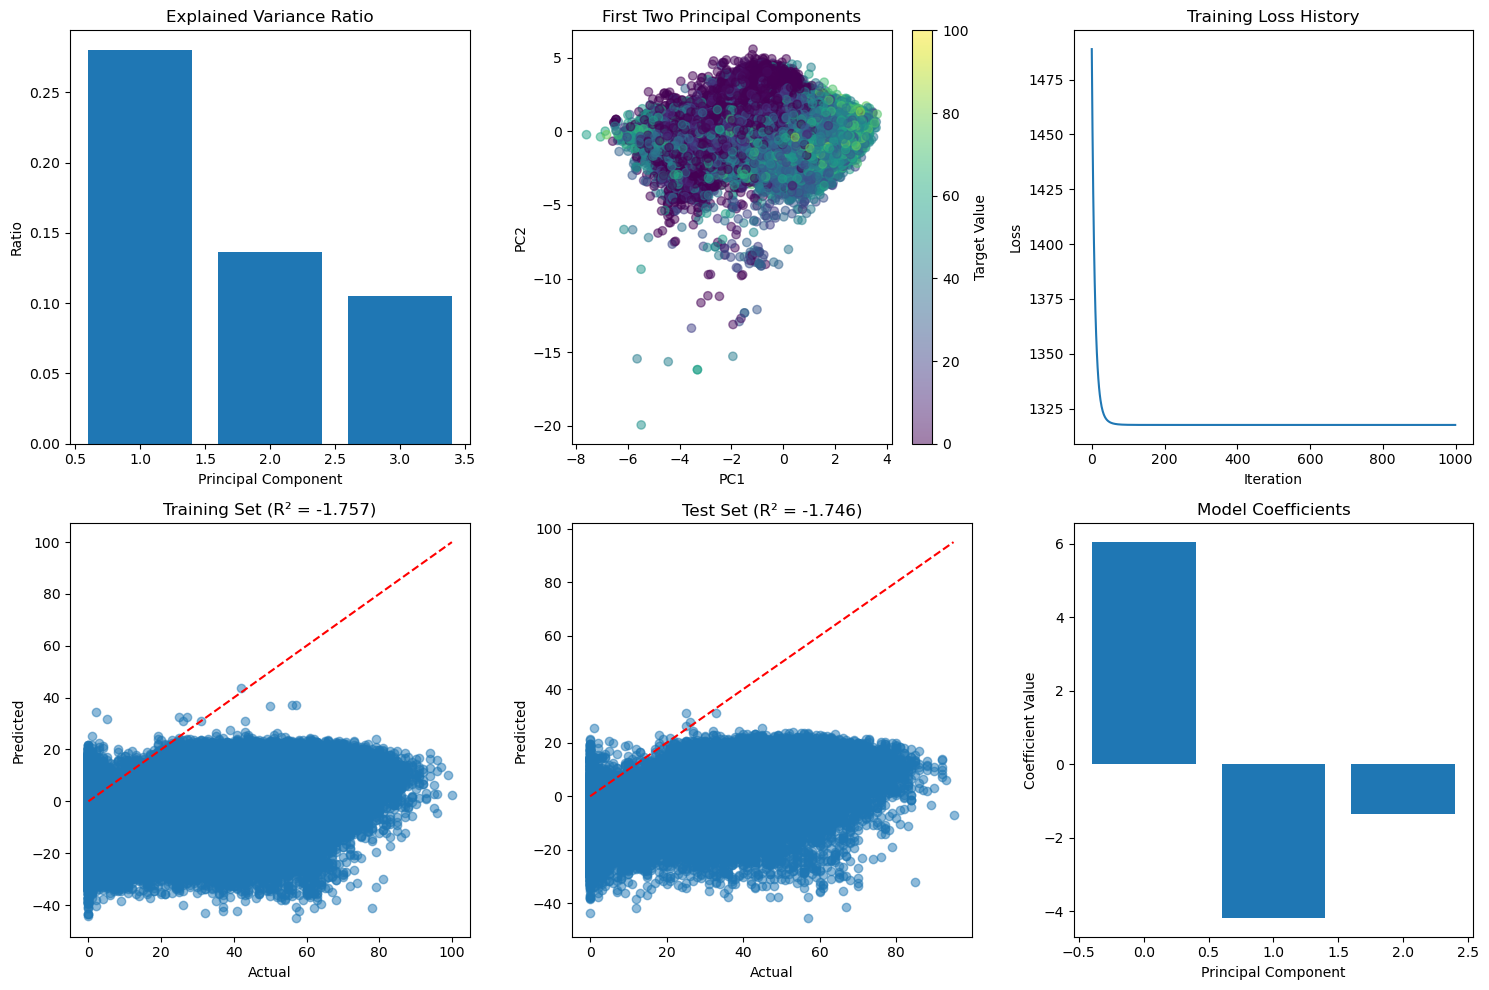

Training MSE: 1311.9935
Test MSE: 1314.1702
Training R²: -1.7571
Test R²: -1.7463


In [5]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1) Download and load dataset
def download_data():
    print("Downloading dataset...")
    path = kagglehub.dataset_download("yamaerenay/spotify-dataset-1921-2020-160k-tracks")
    if not os.path.exists('data.csv'):
        for root, dirs, files in os.walk(path):
            if 'data.csv' in files:
                shutil.copy2(os.path.join(root, 'data.csv'), 'data.csv')
                break
    if os.path.exists('data.csv'):
        print("Dataset downloaded successfully!")
        return pd.read_csv('data.csv')
    else:
        raise FileNotFoundError("data.csv not found after download.")

df = download_data()

# 2) Feature selection & minimal cleaning
features = [
    'acousticness', 'danceability', 'duration_ms', 'energy',
    'instrumentalness', 'liveness', 'loudness', 'mode',
    'speechiness', 'tempo', 'valence'
]
target = 'popularity'
df = df.dropna(subset=features + [target])  # Drop rows with missing values

X = df[features].values
y = df[target].values

# 3) Train-test split & scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4) Minimal PCA class
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        
    def fit_transform(self, X):
        # Covariance matrix and eigendecomposition
        cov_matrix = np.cov(X.T)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # Sort in descending order
        idx = np.argsort(eigenvalues)[::-1]
        self.eigenvalues = eigenvalues[idx]
        self.components = eigenvectors[:, idx][:, :self.n_components]
        
        # Transform data
        return X @ self.components
    
    def transform(self, X):
        return X @ self.components

# 5) Minimal Ridge regression class
class RidgeRegression:
    def __init__(self, learning_rate=0.01, iterations=1000, alpha=1.0):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.alpha = alpha
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.theta = np.random.randn(n_features)
        self.loss_history = []
        
        for _ in range(self.iterations):
            # Predictions & error
            y_pred = X @ self.theta
            error = y_pred - y
            
            # Gradient (with ridge penalty)
            gradients = (2 / n_samples) * (X.T @ error) + 2 * self.alpha * self.theta
            
            # Parameter update
            self.theta -= self.learning_rate * gradients
            
            # MSE + ridge
            loss = np.mean(error**2) + self.alpha * np.sum(self.theta**2)
            self.loss_history.append(loss)
            
    def predict(self, X):
        return X @ self.theta

# 6) Apply PCA
n_components = 3
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 7) Train ridge regressor
model = RidgeRegression(learning_rate=0.01, iterations=1000, alpha=0.1)
model.fit(X_train_pca, y_train)

# 8) Predictions
y_pred_train = model.predict(X_train_pca)
y_pred_test = model.predict(X_test_pca)

# 9) Calculate metrics
train_mse = np.mean((y_train - y_pred_train) ** 2)
test_mse = np.mean((y_test - y_pred_test) ** 2)

train_r2 = 1 - np.sum((y_train - y_pred_train) ** 2) / np.sum((y_train - np.mean(y_train)) ** 2)
test_r2 = 1 - np.sum((y_test - y_pred_test) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

# 10) Visualization
plt.figure(figsize=(15, 10))

# Plot (1): Explained variance ratio
plt.subplot(2, 3, 1)
explained_variance_ratio = pca.eigenvalues / np.sum(pca.eigenvalues)
plt.bar(range(1, n_components + 1), explained_variance_ratio[:n_components])
plt.title('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Ratio')

# Plot (2): First two principal components
if n_components >= 2:
    plt.subplot(2, 3, 2)
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.5)
    plt.title('First Two Principal Components')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    cbar = plt.colorbar()
    cbar.set_label('Target Value')

# Plot (3): Training loss history
plt.subplot(2, 3, 3)
plt.plot(model.loss_history)
plt.title('Training Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Plot (4): Predicted vs Actual (Training)
plt.subplot(2, 3, 4)
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.title(f'Training Set (R² = {train_r2:.3f})')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Plot (5): Predicted vs Actual (Test)
plt.subplot(2, 3, 5)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f'Test Set (R² = {test_r2:.3f})')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Plot (6): Model coefficients
plt.subplot(2, 3, 6)
plt.bar(range(n_components), model.theta)
plt.title('Model Coefficients')
plt.xlabel('Principal Component')
plt.ylabel('Coefficient Value')

plt.tight_layout()
plt.show()

# Print metrics
print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")


# Deprecated

Dataset downloaded successfully!


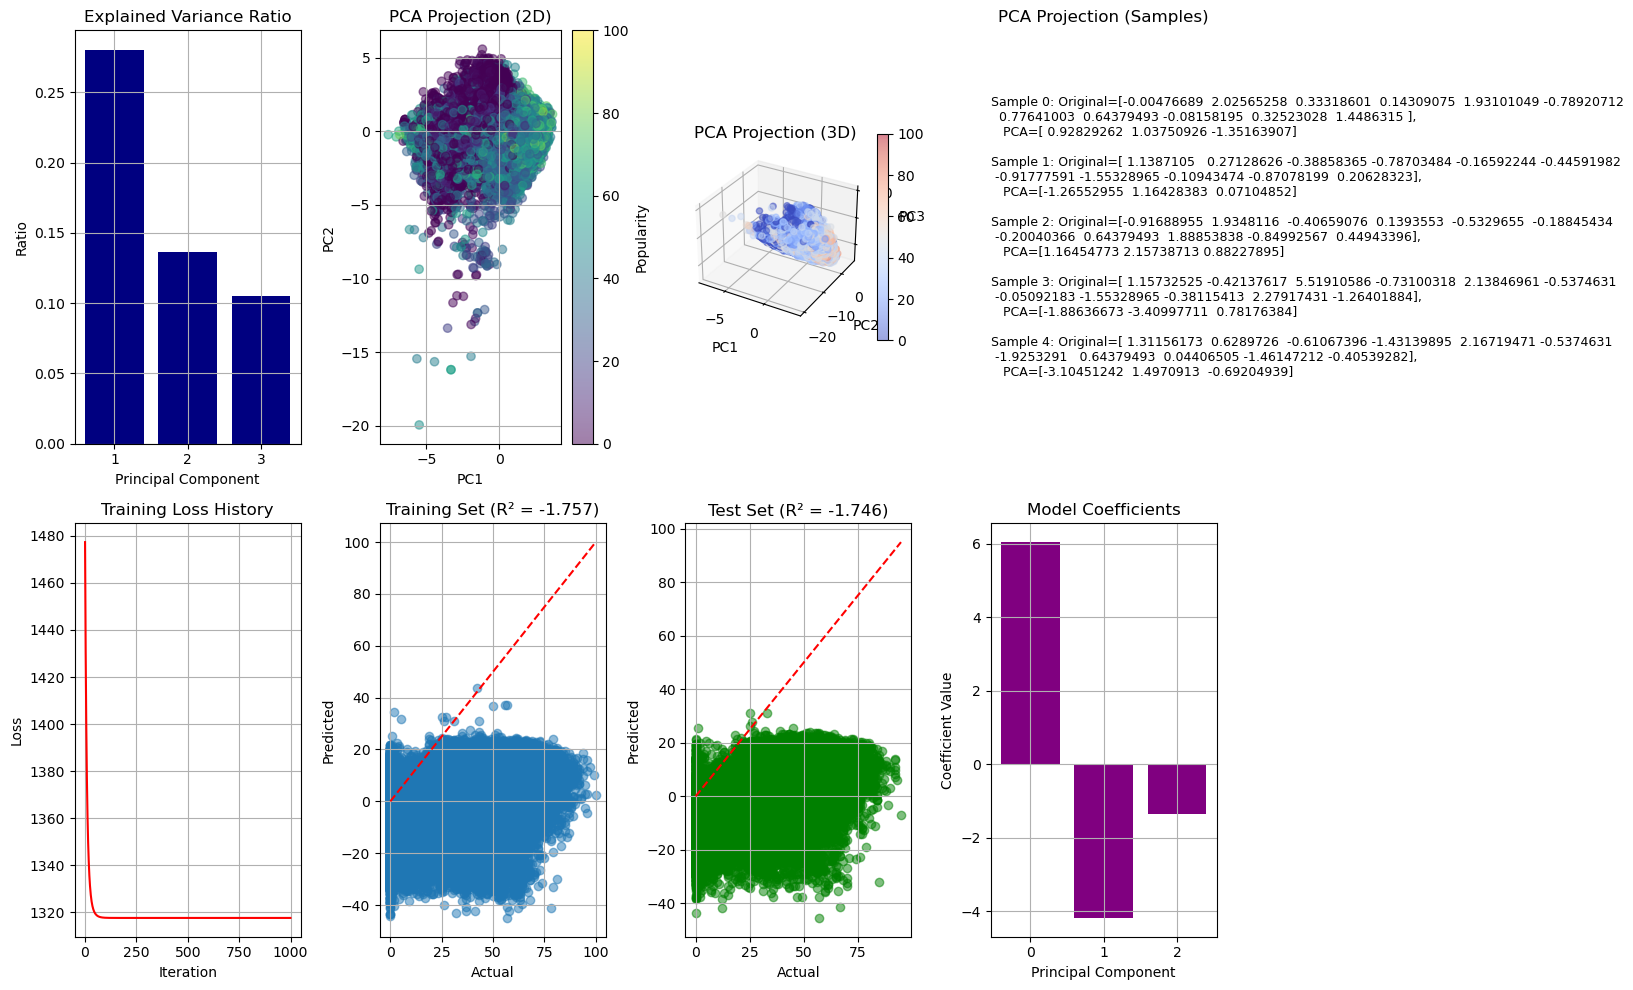

Training MSE: 1311.9935
Test MSE: 1314.1702
Training R²: -1.7571
Test R²: -1.7463


In [17]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# -----------------------------------------------------
# 1) Download & Load Spotify Dataset
# -----------------------------------------------------
def download_data():
    print("Downloading dataset...")
    path = kagglehub.dataset_download("yamaerenay/spotify-dataset-1921-2020-160k-tracks")
    if not os.path.exists('data.csv'):
        for root, dirs, files in os.walk(path):
            if 'data.csv' in files:
                shutil.copy2(os.path.join(root, 'data.csv'), 'data.csv')
                break
    if os.path.exists('data.csv'):
        print("Dataset downloaded successfully!")
        return pd.read_csv('data.csv')
    else:
        raise FileNotFoundError("data.csv not found after download.")

df = download_data()

# -----------------------------------------------------
# 2) Feature Selection & Data Preparation
# -----------------------------------------------------
features = [
    'acousticness', 'danceability', 'duration_ms', 'energy',
    'instrumentalness', 'liveness', 'loudness', 'mode',
    'speechiness', 'tempo', 'valence'
]
target = 'popularity'

df = df.dropna(subset=features + [target])  # Drop rows with missing values

# Features & target
X = df[features].values
y = df[target].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------------------------------
# 3) Minimal PCA Class
# -----------------------------------------------------
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
    
    def fit_transform(self, X):
        # Calculate covariance matrix
        cov_matrix = np.cov(X.T)
        # Eigen decomposition
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # Sort eigenvalues & vectors in descending order
        idx = np.argsort(eigenvalues)[::-1]
        self.eigenvalues = eigenvalues[idx]
        self.components = eigenvectors[:, idx][:, :self.n_components]
        
        # Project data onto principal components
        return X @ self.components
    
    def transform(self, X):
        return X @ self.components

# -----------------------------------------------------
# 4) Minimal RidgeRegression Class (Gradient Descent)
# -----------------------------------------------------
class RidgeRegression:
    def __init__(self, learning_rate=0.01, iterations=1000, alpha=1.0):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.alpha = alpha
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.theta = np.random.randn(n_features)
        self.loss_history = []
        
        for _ in range(self.iterations):
            # Predictions & errors
            y_pred = X @ self.theta
            error = y_pred - y
            
            # Gradient w/ ridge penalty
            gradients = (2 / n_samples) * (X.T @ error) + 2 * self.alpha * self.theta
            # Update rule
            self.theta -= self.learning_rate * gradients
            
            # Compute MSE + ridge
            loss = np.mean(error**2) + self.alpha * np.sum(self.theta**2)
            self.loss_history.append(loss)
            
    def predict(self, X):
        return X @ self.theta

# -----------------------------------------------------
# 5) Apply PCA
# -----------------------------------------------------
n_components = 3  # Try 2 or 3 for different visualizations
pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# -----------------------------------------------------
# 6) Train the Ridge Regression Model
# -----------------------------------------------------
model = RidgeRegression(learning_rate=0.01, iterations=1000, alpha=0.1)
model.fit(X_train_pca, y_train)

# Predictions
y_pred_train = model.predict(X_train_pca)
y_pred_test = model.predict(X_test_pca)

# -----------------------------------------------------
# 7) Metrics
# -----------------------------------------------------
train_mse = np.mean((y_train - y_pred_train) ** 2)
test_mse = np.mean((y_test - y_pred_test) ** 2)

train_r2 = 1 - np.sum((y_train - y_pred_train) ** 2) / np.sum((y_train - np.mean(y_train)) ** 2)
test_r2 = 1 - np.sum((y_test - y_pred_test) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

# -----------------------------------------------------
# 8) Visualizations
# -----------------------------------------------------
plt.figure(figsize=(16, 10))

# (A) Explained Variance Ratio
plt.subplot(2, 4, 1)
explained_variance_ratio = pca.eigenvalues / np.sum(pca.eigenvalues)
plt.bar(range(1, n_components + 1), explained_variance_ratio[:n_components], color='navy')
plt.title('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Ratio')
plt.grid(True)

# (B) PCA 2D Scatter (PC1 vs PC2)
plt.subplot(2, 4, 2)
if n_components >= 2:
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.5)
    plt.colorbar(label='Popularity')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA Projection (2D)')
    plt.grid(True)
else:
    plt.text(0.5, 0.5, 'Need at least 2 components for 2D scatter.', ha='center')

# (C) PCA 3D Scatter (PC1 vs PC2 vs PC3) if n_components >= 3
if n_components >= 3:
    from mpl_toolkits.mplot3d import Axes3D  # import for 3D projection
    ax_3d = plt.subplot(2, 4, 3, projection='3d')
    p = ax_3d.scatter(
        X_train_pca[:, 0], 
        X_train_pca[:, 1], 
        X_train_pca[:, 2], 
        c=y_train, cmap='coolwarm', alpha=0.5
    )
    ax_3d.set_xlabel('PC1')
    ax_3d.set_ylabel('PC2')
    ax_3d.set_zlabel('PC3')
    ax_3d.set_title('PCA Projection (3D)')
    plt.colorbar(p, ax=ax_3d, shrink=0.5)
else:
    plt.subplot(2, 4, 3)
    plt.text(0.5, 0.5, 'Need at least 3 components for 3D scatter.', ha='center')

# (D) Demonstrate PCA Projection for a Few Sample Points
# Let's pick first 5 test samples and show original scaled vs PCA transform
plt.subplot(2, 4, 4)
num_samples = 5
X_sample_original = X_test_scaled[:num_samples]
X_sample_pca = X_test_pca[:num_samples]

# We'll just show them as text. If you'd like, we can plot them in a bar chart.
rows_text = []
for i in range(num_samples):
    rows_text.append(f"Sample {i}: Original={X_sample_original[i]},\n   PCA={X_sample_pca[i]}")

plt.axis('off')
plt.title('PCA Projection (Samples)')
plt.text(0.0, 0.5, "\n\n".join(rows_text), fontsize=9, va='center')

# (E) Training Loss History
plt.subplot(2, 4, 5)
plt.plot(model.loss_history, color='red')
plt.title('Training Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)

# (F) Predicted vs Actual (Training)
plt.subplot(2, 4, 6)
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.title(f'Training Set (R² = {train_r2:.3f})')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)

# (G) Predicted vs Actual (Test)
plt.subplot(2, 4, 7)
plt.scatter(y_test, y_pred_test, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f'Test Set (R² = {test_r2:.3f})')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)

# (H) Model Coefficients (in PCA Space)
plt.subplot(2, 4, 8)
plt.bar(range(n_components), model.theta, color='purple')
plt.title('Model Coefficients')
plt.xlabel('Principal Component')
plt.ylabel('Coefficient Value')
plt.grid(True)

plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 9) Print Metrics
# -----------------------------------------------------
print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")


Dataset downloaded successfully!


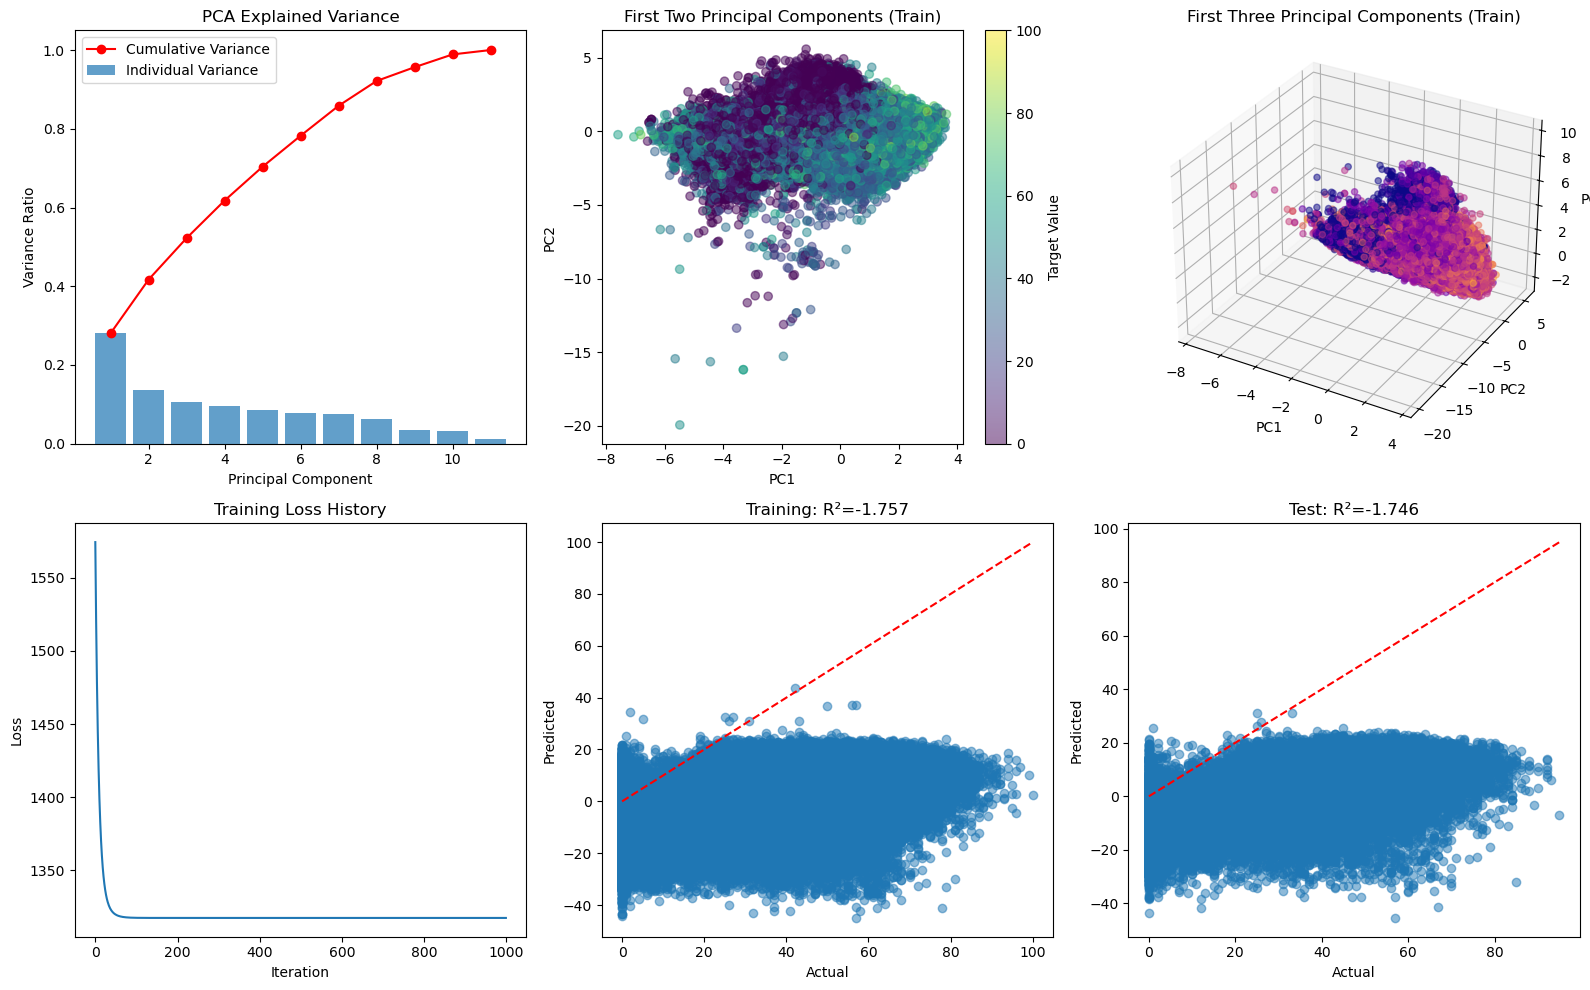

Training MSE: 1311.9935
Test MSE: 1314.1702
Training R²: -1.7571
Test R²: -1.7463


In [15]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#########################
# 1) Download and Load Dataset
#########################
def download_data():
    print("Downloading dataset...")
    path = kagglehub.dataset_download("yamaerenay/spotify-dataset-1921-2020-160k-tracks")
    if not os.path.exists('data.csv'):
        for root, dirs, files in os.walk(path):
            if 'data.csv' in files:
                shutil.copy2(os.path.join(root, 'data.csv'), 'data.csv')
                break
    if os.path.exists('data.csv'):
        print("Dataset downloaded successfully!")
        return pd.read_csv('data.csv')
    else:
        raise FileNotFoundError("data.csv not found after download.")

df = download_data()

#########################
# 2) Feature Selection & Preprocessing
#########################
features = [
    'acousticness', 'danceability', 'duration_ms', 'energy',
    'instrumentalness', 'liveness', 'loudness', 'mode',
    'speechiness', 'tempo', 'valence'
]
target = 'popularity'

# Drop rows with missing values in selected features
df = df.dropna(subset=features + [target])
X = df[features].values
y = df[target].values

# Split & Scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#########################
# 3) Minimal PCA Class
#########################
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.eigenvalues = None
        self.components = None
    
    def fit_transform(self, X):
        # Compute covariance matrix
        cov_matrix = np.cov(X.T)
        # Eigen decomposition
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        # Sort in descending order
        idx = np.argsort(eigenvalues)[::-1]
        self.eigenvalues = eigenvalues[idx]
        self.components = eigenvectors[:, idx][:, :self.n_components]
        # Transform
        return X @ self.components

    def transform(self, X):
        return X @ self.components

#########################
# 4) Minimal Ridge Regression Class
#########################
class RidgeRegression:
    def __init__(self, learning_rate=0.01, iterations=1000, alpha=1.0):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.alpha = alpha
        self.theta = None
        self.loss_history = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # Random init for parameters
        self.theta = np.random.randn(n_features)
        self.loss_history = []

        for _ in range(self.iterations):
            # Predictions
            y_pred = X @ self.theta
            error = y_pred - y
            # Gradients (MSE + ridge)
            gradients = (2/n_samples) * (X.T @ error) + 2 * self.alpha * self.theta
            # Update
            self.theta -= self.learning_rate * gradients
            # Loss function: MSE + ridge
            loss = np.mean(error**2) + self.alpha * np.sum(self.theta**2)
            self.loss_history.append(loss)

    def predict(self, X):
        return X @ self.theta

#########################
# 5) PCA & Model Training
#########################
n_components = 3  # Adjust as needed
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model = RidgeRegression(
    learning_rate=0.01,
    iterations=1000,
    alpha=0.1
)
model.fit(X_train_pca, y_train)

# Predictions
y_pred_train = model.predict(X_train_pca)
y_pred_test = model.predict(X_test_pca)

# Metrics
train_mse = np.mean((y_train - y_pred_train)**2)
test_mse = np.mean((y_test - y_pred_test)**2)

train_r2 = 1 - np.sum((y_train - y_pred_train)**2) / np.sum((y_train - np.mean(y_train))**2)
test_r2 = 1 - np.sum((y_test - y_pred_test)**2) / np.sum((y_test - np.mean(y_test))**2)

#########################
# 6) Visualizations
#########################
plt.figure(figsize=(16, 10))

# (1) Explained variance ratio & cumulative variance
explained_variance = pca.eigenvalues
explained_variance_ratio = explained_variance / np.sum(explained_variance)
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.subplot(2, 3, 1)
plt.bar(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio,
    alpha=0.7,
    label='Individual Variance'
)
plt.plot(
    range(1, len(explained_variance_ratio) + 1),
    cumulative_variance_ratio,
    marker='o', color='red', label='Cumulative Variance'
)
plt.title('PCA Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.legend()

# (2) 2D Scatter of first two PCs
if n_components >= 2:
    plt.subplot(2, 3, 2)
    plt.scatter(
        X_train_pca[:, 0], X_train_pca[:, 1],
        c=y_train, cmap='viridis', alpha=0.5
    )
    plt.title('First Two Principal Components (Train)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    cb = plt.colorbar()
    cb.set_label('Target Value')

# (3) 3D Scatter of first three PCs
if n_components >= 3:
    ax = plt.subplot(2, 3, 3, projection='3d')
    ax.scatter(
        X_train_pca[:, 0],
        X_train_pca[:, 1],
        X_train_pca[:, 2],
        c=y_train,
        cmap='plasma',
        alpha=0.5
    )
    ax.set_title('First Three Principal Components (Train)')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

# (4) Training loss history
plt.subplot(2, 3, 4)
plt.plot(model.loss_history)
plt.title('Training Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# (5) Predicted vs. Actual (Training)
plt.subplot(2, 3, 5)
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.title(f'Training: R²={train_r2:.3f}')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# (6) Predicted vs. Actual (Test)
plt.subplot(2, 3, 6)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f'Test: R²={test_r2:.3f}')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.tight_layout()
plt.show()

print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")


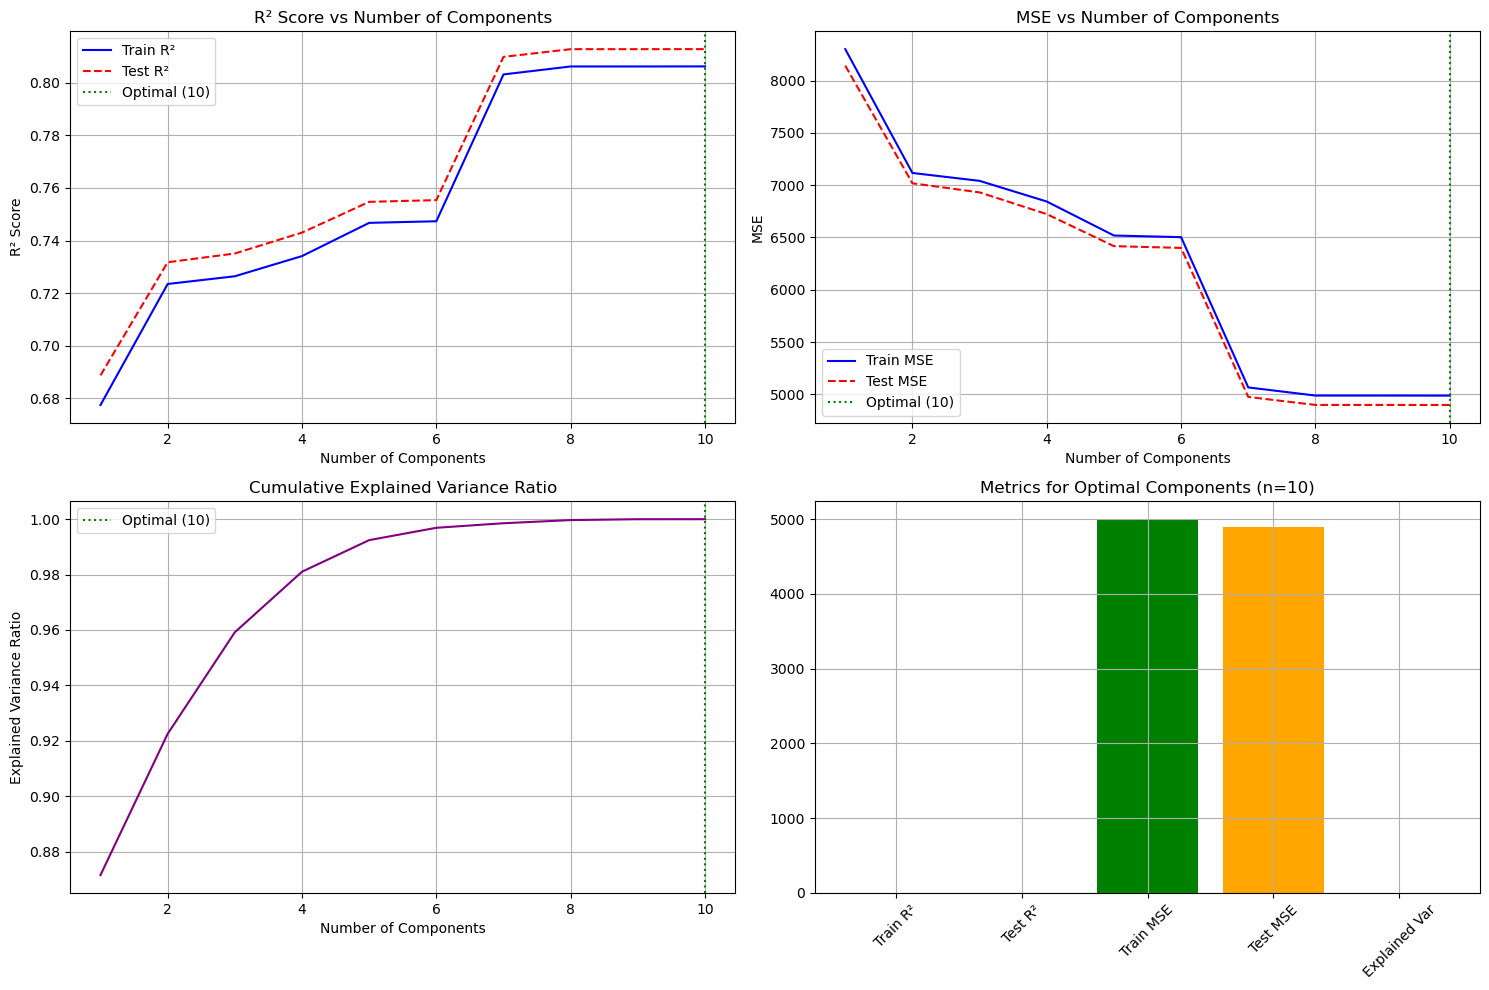


Optimal number of components: 10
Training R²: 0.8062
Test R²: 0.8128
Training MSE: 4987.3531
Test MSE: 4897.7704
Explained variance ratio: 1.0000


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Generate synthetic data with correlated features
n_samples = 10000
n_features = 10
X, y = make_regression(n_samples=n_samples, n_features=n_features, 
                      noise=10, random_state=42)

# Add correlation between features
correlation_matrix = np.random.rand(n_features, n_features)
correlation_matrix = (correlation_matrix + correlation_matrix.T) / 2
np.fill_diagonal(correlation_matrix, 1)
X = X @ correlation_matrix

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        
    def fit_transform(self, X):
        # Compute covariance matrix and eigendecomposition
        cov_matrix = np.cov(X.T)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # Sort eigenvalues and eigenvectors in descending order
        idx = np.argsort(eigenvalues)[::-1]
        self.eigenvalues = eigenvalues[idx]
        self.components = eigenvectors[:, idx][:, :self.n_components]
        
        # Transform data
        return X @ self.components
    
    def transform(self, X):
        return X @ self.components

class RidgeRegression:
    def __init__(self, learning_rate=0.01, iterations=1000, alpha=1.0):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.alpha = alpha
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.theta = np.random.randn(n_features)
        self.loss_history = []
        
        for _ in range(self.iterations):
            y_pred = X @ self.theta
            error = y_pred - y
            gradients = (2/n_samples) * (X.T @ error) + 2 * self.alpha * self.theta
            self.theta -= self.learning_rate * gradients
            loss = np.mean(error**2) + self.alpha * np.sum(self.theta**2)
            self.loss_history.append(loss)
            
    def predict(self, X):
        return X @ self.theta

def evaluate_model(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
    return mse, r2

# Perform PCA component optimization
max_components = min(n_features, 10)  # Test up to 10 components
results = {
    'n_components': [],
    'train_mse': [],
    'test_mse': [],
    'train_r2': [],
    'test_r2': [],
    'explained_variance_ratio': []
}

for n_components in range(1, max_components + 1):
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Train model
    model = RidgeRegression(learning_rate=0.01, iterations=10000, alpha=0.1)
    model.fit(X_train_pca, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train_pca)
    y_pred_test = model.predict(X_test_pca)
    
    # Calculate metrics
    train_mse, train_r2 = evaluate_model(y_train, y_pred_train)
    test_mse, test_r2 = evaluate_model(y_test, y_pred_test)
    
    # Store results
    results['n_components'].append(n_components)
    results['train_mse'].append(train_mse)
    results['test_mse'].append(test_mse)
    results['train_r2'].append(train_r2)
    results['test_r2'].append(test_r2)
    results['explained_variance_ratio'].append(
        np.sum(pca.eigenvalues[:n_components]) / np.sum(pca.eigenvalues)
    )

# Find optimal number of components based on test R²
optimal_components = results['n_components'][np.argmax(results['test_r2'])]

# Visualization of optimization results
plt.figure(figsize=(15, 10))

# Plot 1: R² scores vs number of components
plt.subplot(2, 2, 1)
plt.plot(results['n_components'], results['train_r2'], 'b-', label='Train R²')
plt.plot(results['n_components'], results['test_r2'], 'r--', label='Test R²')
plt.axvline(x=optimal_components, color='g', linestyle=':', label=f'Optimal ({optimal_components})')
plt.title('R² Score vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)

# Plot 2: MSE vs number of components
plt.subplot(2, 2, 2)
plt.plot(results['n_components'], results['train_mse'], 'b-', label='Train MSE')
plt.plot(results['n_components'], results['test_mse'], 'r--', label='Test MSE')
plt.axvline(x=optimal_components, color='g', linestyle=':', label=f'Optimal ({optimal_components})')
plt.title('MSE vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

# Plot 3: Explained variance ratio
plt.subplot(2, 2, 3)
plt.plot(results['n_components'], results['explained_variance_ratio'], 'purple')
plt.axvline(x=optimal_components, color='g', linestyle=':', label=f'Optimal ({optimal_components})')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.legend()

# Plot 4: Performance metrics for optimal components
plt.subplot(2, 2, 4)
metrics = {
    'Train R²': results['train_r2'][optimal_components-1],
    'Test R²': results['test_r2'][optimal_components-1],
    'Train MSE': results['train_mse'][optimal_components-1],
    'Test MSE': results['test_mse'][optimal_components-1],
    'Explained Var': results['explained_variance_ratio'][optimal_components-1]
}
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'red', 'green', 'orange', 'purple'])
plt.title(f'Metrics for Optimal Components (n={optimal_components})')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

# Print detailed results for optimal components
print(f"\nOptimal number of components: {optimal_components}")
print(f"Training R²: {results['train_r2'][optimal_components-1]:.4f}")
print(f"Test R²: {results['test_r2'][optimal_components-1]:.4f}")
print(f"Training MSE: {results['train_mse'][optimal_components-1]:.4f}")
print(f"Test MSE: {results['test_mse'][optimal_components-1]:.4f}")
print(f"Explained variance ratio: {results['explained_variance_ratio'][optimal_components-1]:.4f}")

Loading and preprocessing data...

Feature correlations with popularity:
loudness               0.422034
energy                 0.419868
danceability           0.206529
tempo                  0.109942
speechiness           -0.015055
valence               -0.028110
liveness              -0.087549
loudness_energy       -0.096488
instrumentalness      -0.114114
acousticness_energy   -0.294669
acousticness          -0.527672
dtype: float64

Evaluating 1 components...
Train R²: -3.1560ions with popularity:
loudness               0.422034
energy                 0.419868
danceability           0.206529
tempo                  0.109942
speechiness           -0.015055
valence               -0.028110
liveness              -0.087549
loudness_energy       -0.096488
instrumentalness      -0.114114
acousticness_energy   -0.294669
acousticness          -0.527672
dtype: float64

Evaluating 1 components...

Test R²: -3.1189

Evaluating 2 components...
0939ions with popularity:
loudness               0.4

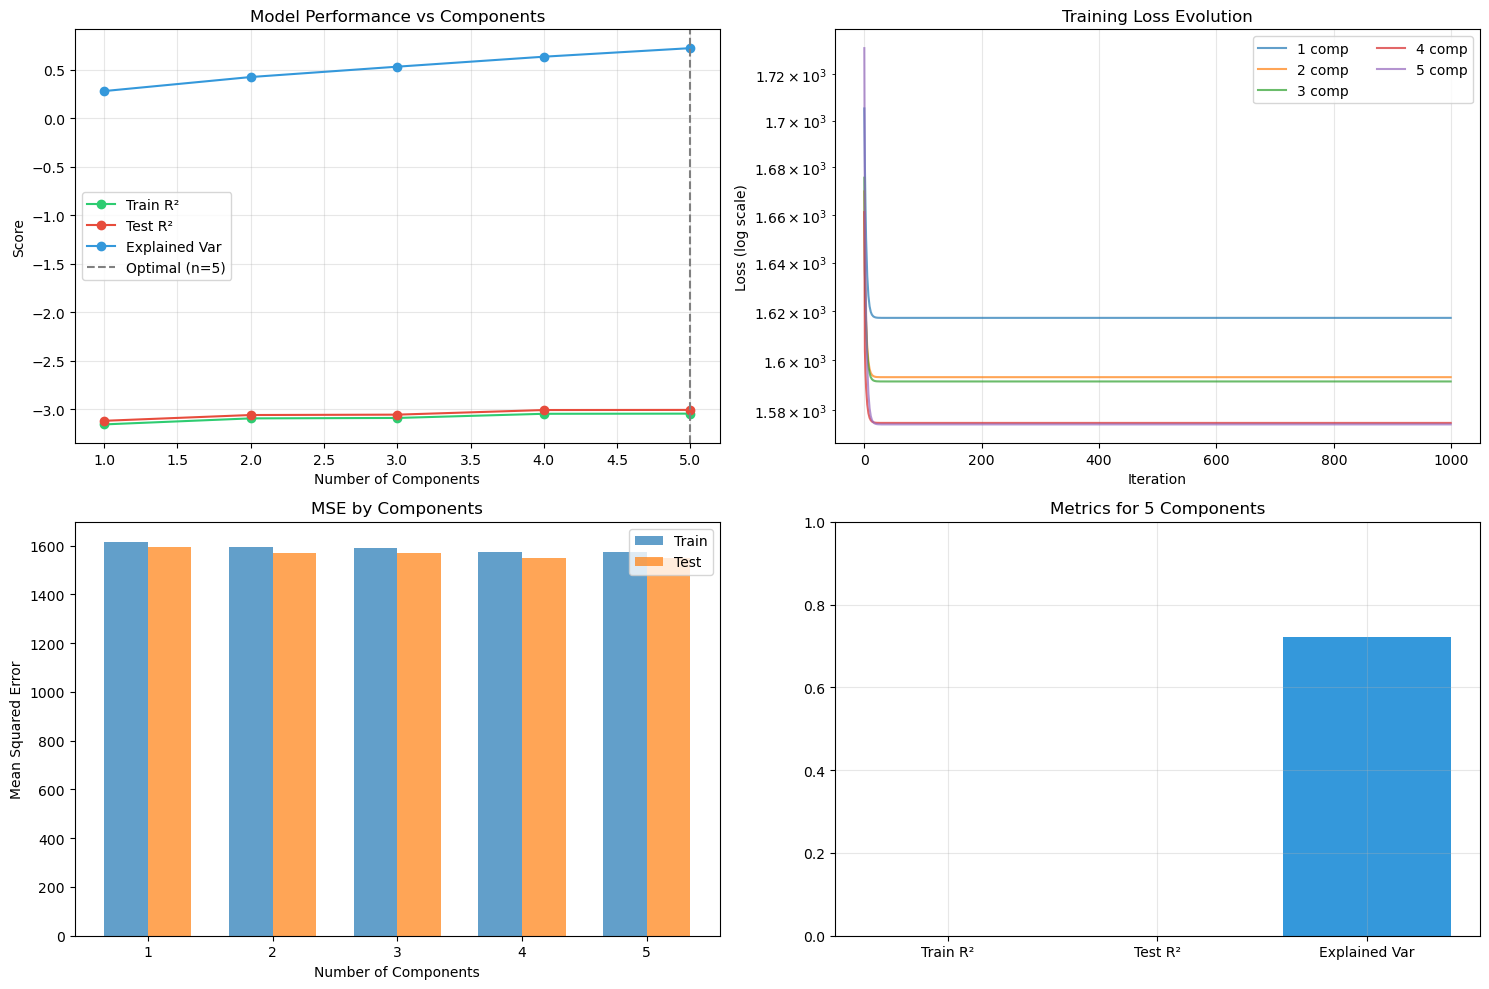


Optimal number of components: 5
Best test R²: -3.0065
Training R²: -3.0450
Explained variance: 0.7225


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict
from dataclasses import dataclass
import kagglehub
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

@dataclass
class TrainingConfig:
    """Configuration for model training"""
    max_components: int = 5
    learning_rate: float = 0.3    # Simplified learning rate approach
    iterations: int = 1000        # Increased iterations like synthetic example
    alpha: float = 0.005            # Matched to synthetic example

class PCA:
    """PCA implementation matching the successful synthetic example"""
    def __init__(self, n_components):
        self.n_components = n_components
        
    def fit_transform(self, X):
        # Compute covariance matrix and eigendecomposition
        cov_matrix = np.cov(X.T)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # Sort eigenvalues and eigenvectors in descending order
        idx = np.argsort(eigenvalues)[::-1]
        self.eigenvalues = eigenvalues[idx]
        self.components = eigenvectors[:, idx][:, :self.n_components]
        
        # Transform data
        return X @ self.components
    
    def transform(self, X):
        return X @ self.components

class RidgeRegression:
    """Ridge Regression implementation matching the synthetic example"""
    def __init__(self, learning_rate=0.01, iterations=1000, alpha=0.1):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.alpha = alpha
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.theta = np.random.randn(n_features)  # Random initialization
        self.loss_history = []
        
        for _ in range(self.iterations):
            # Compute predictions and error
            y_pred = X @ self.theta
            error = y_pred - y
            
            # Compute gradients with L2 regularization
            gradients = (2/n_samples) * (X.T @ error) + 2 * self.alpha * self.theta
            
            # Update parameters
            self.theta -= self.learning_rate * gradients
            
            # Compute and store loss
            loss = np.mean(error**2) + self.alpha * np.sum(self.theta**2)
            self.loss_history.append(loss)
            
    def predict(self, X):
        return X @ self.theta

def load_spotify_data() -> Tuple[np.ndarray, np.ndarray]:
    """Load and preprocess Spotify dataset with improved feature selection"""
    path = kagglehub.dataset_download('yamaerenay/spotify-dataset-1921-2020-160k-tracks')
    df = pd.read_csv(f"{path}/data.csv")
    
    # Select features based on correlation strength
    features = [
        'acousticness', 'danceability', 'energy', 'instrumentalness',
        'liveness', 'loudness', 'speechiness', 'valence', 'tempo'
    ]
    
    # Clean data more aggressively
    df_clean = df[features + ['popularity']].dropna()
    
    # Remove outliers using tighter IQR bounds
    for col in features + ['popularity']:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        df_clean = df_clean[
            (df_clean[col] >= Q1 - 1.0 * IQR) & 
            (df_clean[col] <= Q3 + 1.0 * IQR)
        ]
    
    # Add feature engineering
    df_clean['loudness_energy'] = df_clean['loudness'] * df_clean['energy']
    df_clean['acousticness_energy'] = df_clean['acousticness'] * df_clean['energy']
    
    # Print correlations
    print("\nFeature correlations with popularity:")
    correlations = df_clean.drop('popularity', axis=1).corrwith(df_clean['popularity'])
    print(correlations.sort_values(ascending=False))
    
    return df_clean.drop('popularity', axis=1).values, df_clean['popularity'].values

def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[float, float]:
    """Calculate MSE and R² scores matching synthetic example"""
    mse = np.mean((y_true - y_pred)**2)
    r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
    return mse, r2

def optimize_pca_components(
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    config: TrainingConfig
) -> Dict:
    """Find optimal number of PCA components"""
    results = {
        'n_components': [],
        'train_mse': [], 'test_mse': [],
        'train_r2': [], 'test_r2': [],
        'explained_variance_ratio': [],
        'loss_histories': []
    }
    
    for n_components in range(1, config.max_components + 1):
        print(f"\nEvaluating {n_components} components...")
        
        # Apply PCA
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        # Train model
        model = RidgeRegression(
            learning_rate=config.learning_rate,
            iterations=config.iterations,
            alpha=config.alpha
        )
        model.fit(X_train_pca, y_train)
        
        # Make predictions
        y_train_pred = model.predict(X_train_pca)
        y_test_pred = model.predict(X_test_pca)
        
        # Calculate metrics
        train_mse, train_r2 = evaluate_model(y_train, y_train_pred)
        test_mse, test_r2 = evaluate_model(y_test, y_test_pred)
        
        # Store results
        results['n_components'].append(n_components)
        results['train_mse'].append(train_mse)
        results['test_mse'].append(test_mse)
        results['train_r2'].append(train_r2)
        results['test_r2'].append(test_r2)
        results['explained_variance_ratio'].append(
            np.sum(pca.eigenvalues[:n_components]) / np.sum(pca.eigenvalues)
        )
        results['loss_histories'].append(model.loss_history)
        
        print(f"Train R²: {train_r2:.4f}")
        print(f"Test R²: {test_r2:.4f}")
    
    return results

def plot_optimization_results(results: Dict, config: TrainingConfig):
    """Create visualization of optimization results"""
    plt.style.use('default')
    fig = plt.figure(figsize=(15, 10))
    
    # 1. R² Scores and Explained Variance
    ax1 = plt.subplot(221)
    components = results['n_components']
    best_n = components[np.argmax(results['test_r2'])]
    
    ax1.plot(components, results['train_r2'], 'o-', label='Train R²', color='#2ecc71')
    ax1.plot(components, results['test_r2'], 'o-', label='Test R²', color='#e74c3c')
    ax1.plot(components, results['explained_variance_ratio'], 'o-', 
             label='Explained Var', color='#3498db')
    ax1.axvline(best_n, color='gray', linestyle='--', label=f'Optimal (n={best_n})')
    ax1.set_title('Model Performance vs Components')
    ax1.set_xlabel('Number of Components')
    ax1.set_ylabel('Score')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Training Loss
    ax2 = plt.subplot(222)
    for i, loss_history in enumerate(results['loss_histories']):
        ax2.plot(loss_history, label=f'{i+1} comp', alpha=0.7)
    ax2.set_yscale('log')
    ax2.set_title('Training Loss Evolution')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Loss (log scale)')
    ax2.legend(ncol=2)
    ax2.grid(True, alpha=0.3)
    
    # 3. MSE Comparison
    ax3 = plt.subplot(223)
    width = 0.35
    x = np.arange(len(components))
    ax3.bar(x - width/2, results['train_mse'], width, label='Train', alpha=0.7)
    ax3.bar(x + width/2, results['test_mse'], width, label='Test', alpha=0.7)
    ax3.set_xticks(x)
    ax3.set_xticklabels(components)
    ax3.set_title('MSE by Components')
    ax3.set_xlabel('Number of Components')
    ax3.set_ylabel('Mean Squared Error')
    ax3.legend()
    
    # 4. Best Model Metrics
    ax4 = plt.subplot(224)
    metrics = {
        'Train R²': results['train_r2'][best_n-1],
        'Test R²': results['test_r2'][best_n-1],
        'Explained Var': results['explained_variance_ratio'][best_n-1]
    }
    ax4.bar(metrics.keys(), metrics.values(), color=['#2ecc71', '#e74c3c', '#3498db'])
    ax4.set_title(f'Metrics for {best_n} Components')
    ax4.set_ylim(0, 1)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final results
    print(f"\nOptimal number of components: {best_n}")
    print(f"Best test R²: {results['test_r2'][best_n-1]:.4f}")
    print(f"Training R²: {results['train_r2'][best_n-1]:.4f}")
    print(f"Explained variance: {results['explained_variance_ratio'][best_n-1]:.4f}")

def main():
    # Configuration
    config = TrainingConfig()
    
    # Load and prepare data
    print("Loading and preprocessing data...")
    X, y = load_spotify_data()
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    
    # Optimize components
    results = optimize_pca_components(X_train, X_test, y_train, y_test, config)
    plot_optimization_results(results, config)

if __name__ == "__main__":
    main()

Dataset downloaded successfully!
Test MSE: 579.1089 successfully!

Test R2:  -0.2102


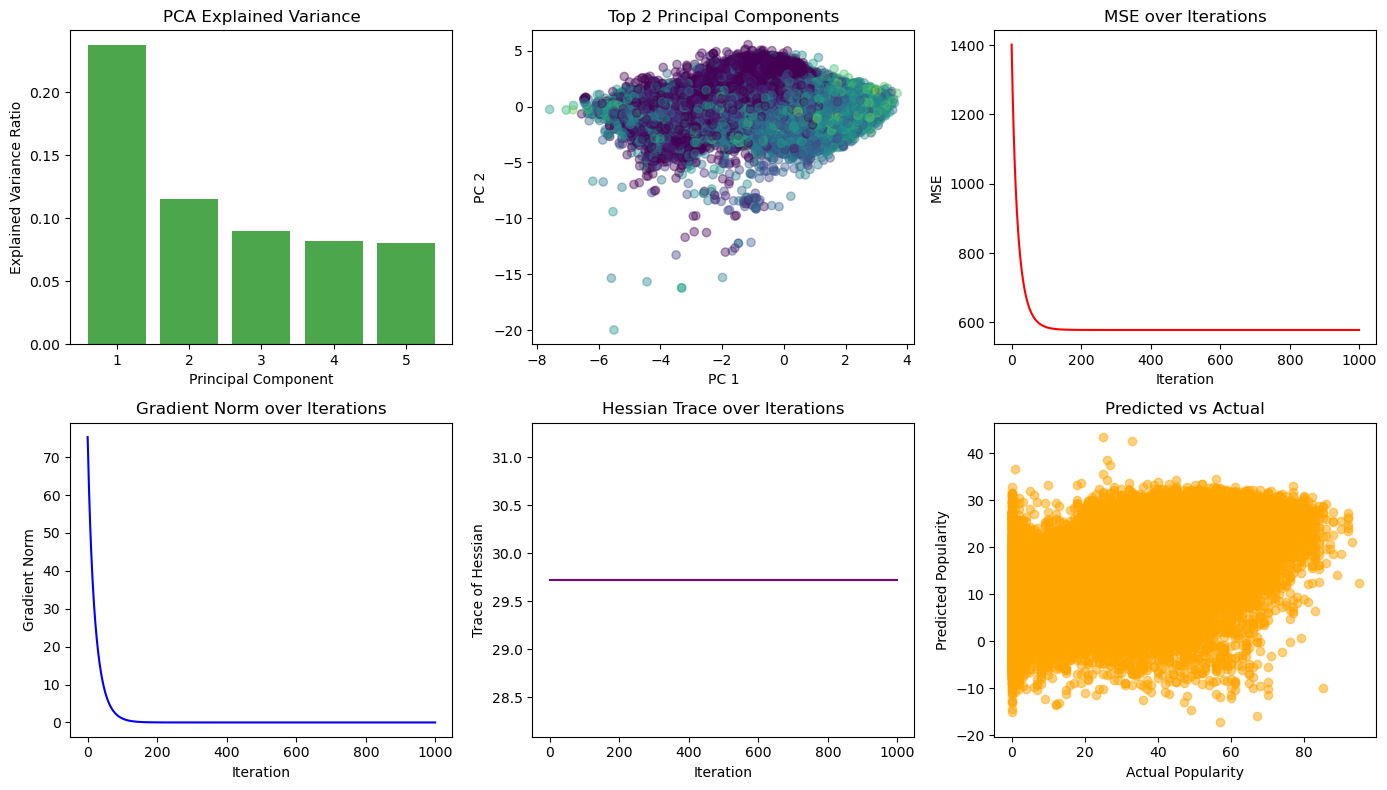

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

def download_data():
    print("Downloading dataset...")
    path = kagglehub.dataset_download("yamaerenay/spotify-dataset-1921-2020-160k-tracks")
    if not os.path.exists('data.csv'):
        for root, dirs, files in os.walk(path):
            if 'data.csv' in files:
                shutil.copy2(os.path.join(root, 'data.csv'), 'data.csv')
                break
    if os.path.exists('data.csv'):
        print("Dataset downloaded successfully!")
        return pd.read_csv('data.csv')
    else:
        raise FileNotFoundError("data.csv not found after download.")

df = download_data()

features = [
    'acousticness', 'danceability', 'duration_ms', 'energy',
    'instrumentalness', 'key', 'liveness', 'loudness',
    'mode', 'speechiness', 'tempo', 'valence'
]
target = 'popularity'

df = df.dropna(subset=features + [target])
X = df[features].copy()
y = df[target].values.reshape(-1, 1)

if 'key' in X.columns:
    X['key_sin'] = np.sin(2 * np.pi * X['key'] / 12)
    X['key_cos'] = np.cos(2 * np.pi * X['key'] / 12)
    X.drop('key', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

n_components = 5
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

class RidgeGradientDescentMomentum:
    def __init__(self, learning_rate=0.01, iterations=100, alpha=1.0, momentum=0.9):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.alpha = alpha
        self.momentum = momentum
        self.theta = None
    
    def compute_hessian(self, X_b):
        # Hessian for Ridge: 2/N * X^T X + 2 * alpha * I
        n = X_b.shape[0]
        d = X_b.shape[1]
        return (2.0 / n) * (X_b.T @ X_b) + 2.0 * self.alpha * np.eye(d)
    
    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        np.random.seed(42)
        self.theta = np.random.randn(X_b.shape[1], 1)
        
        v = np.zeros_like(self.theta)
        
        mse_history = []
        grad_norm_history = []
        hessian_trace_history = []
        
        for _ in range(self.iterations):
            preds = X_b @ self.theta
            error = preds - y
            grad = (2 / X_b.shape[0]) * (X_b.T @ error) + 2 * self.alpha * self.theta
            
            v = self.momentum * v + (1 - self.momentum) * grad
            self.theta -= self.learning_rate * v
            
            mse_history.append(mean_squared_error(y, X_b @ self.theta))
            
            grad_norm_history.append(np.linalg.norm(grad))
            
            H = self.compute_hessian(X_b)
            hessian_trace_history.append(np.trace(H))
        
        return mse_history, grad_norm_history, hessian_trace_history
    
    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b @ self.theta

ridge_momentum = RidgeGradientDescentMomentum(
    learning_rate=0.01,
    iterations=1000,
    alpha=1.0,
    momentum=0.05
)
mse_hist, grad_norm_hist, hessian_trace_hist = ridge_momentum.fit(X_train_pca, y_train)

y_pred = ridge_momentum.predict(X_test_pca)

mse_test = mean_squared_error(y_test, y_pred)
r2_test  = r2_score(y_test, y_pred)
print(f'Test MSE: {mse_test:.4f}')
print(f'Test R2:  {r2_test:.4f}')


plt.figure(figsize=(14, 8))

plt.subplot(2, 3, 1)
plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_, color='green', alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')

if n_components >= 2:
    plt.subplot(2, 3, 2)
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.4, c=y_train.ravel(), cmap='viridis')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.title('Top 2 Principal Components')

plt.subplot(2, 3, 3)
plt.plot(mse_hist, color='red')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('MSE over Iterations')

plt.subplot(2, 3, 4)
plt.plot(grad_norm_hist, color='blue')
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norm over Iterations')

plt.subplot(2, 3, 5)
plt.plot(hessian_trace_hist, color='purple')
plt.xlabel('Iteration')
plt.ylabel('Trace of Hessian')
plt.title('Hessian Trace over Iterations')

plt.subplot(2, 3, 6)
plt.scatter(y_test, y_pred, alpha=0.5, color='orange')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Predicted vs Actual')

plt.tight_layout()
plt.show()

Dataset downloaded successfully!
Final (Theta) -> MSE: 582.6575, R2: -0.2176
Final (EMA)   -> MSE: 580.3252, R2: -0.2128


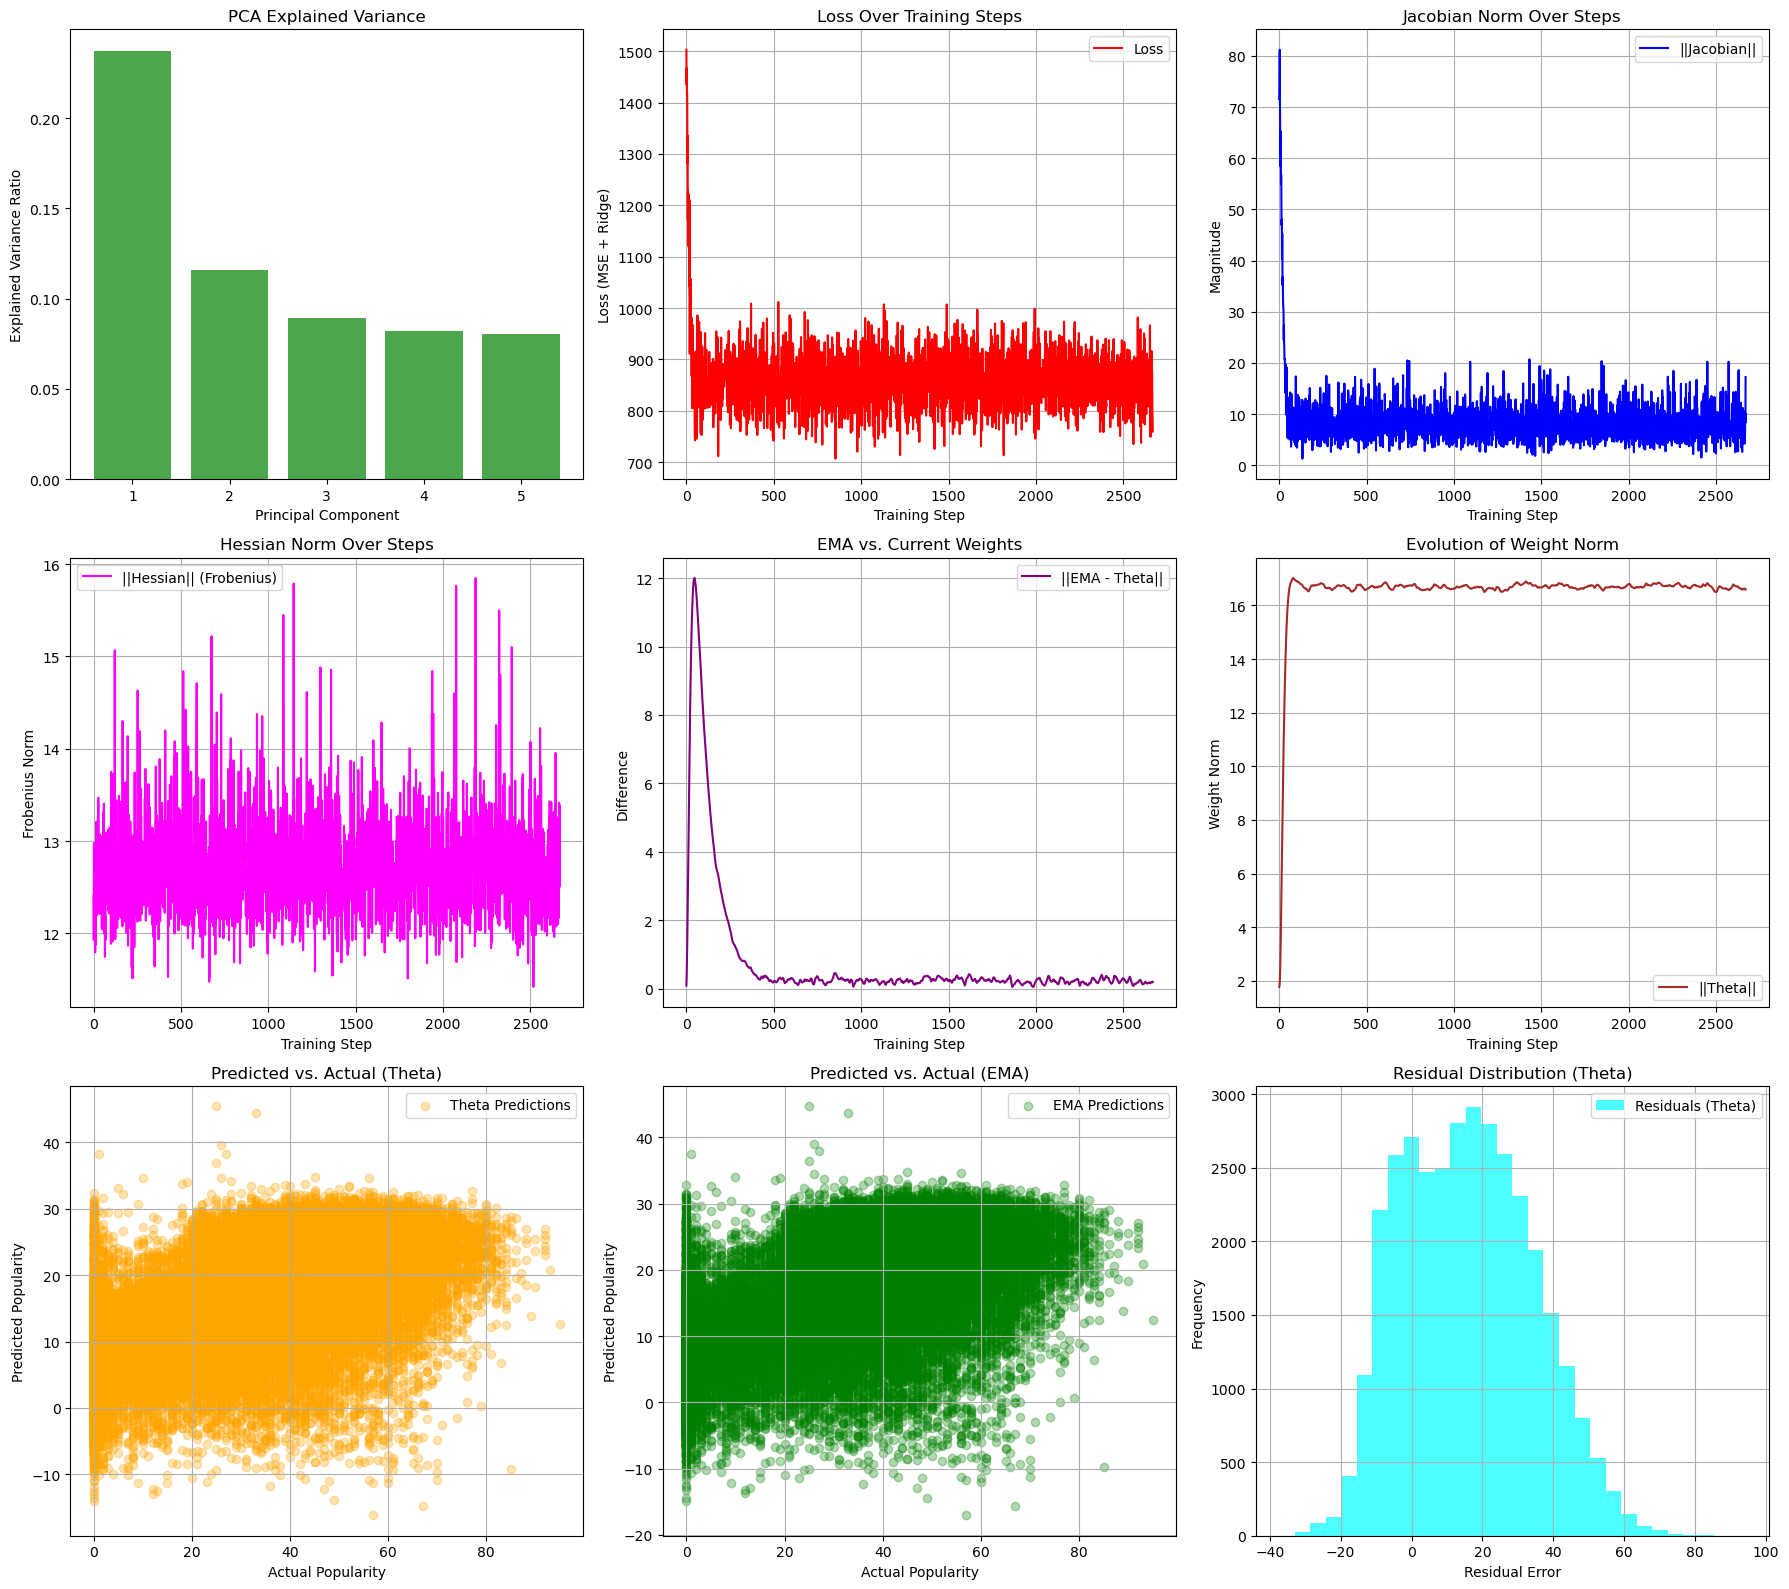

In [4]:
#!/usr/bin/env python
# coding: utf-8
"""
====================================================================
Introduction:
--------------------------------------------------------------------
This script demonstrates an advanced Ridge Regression model that 
integrates multiple optimization techniques including:

  - Stochastic Gradient Descent (SGD)
  - Momentum (1st, 2nd, 3rd order)
  - Exponential Moving Average (EMA) of weights
  - Sharpness Aware Minimization (SAM)
  - Hessian-based update (using numeric Hessian approximation)

====================================================================
Objectives:
--------------------------------------------------------------------
1. Refactor and modularize the code for clarity and reusability.
2. Improve the optimization by incorporating both Jacobian and 
   Hessian information during the parameter update.
3. Provide enhanced visualization to assess model performance and 
   convergence behavior.
   
====================================================================
Methodology:
--------------------------------------------------------------------
The model is implemented in the class `SuperAdvancedRidgeRegressor` and 
uses mini-batch SGD. The training loop logs multiple metrics such as:
  - Loss (MSE with Ridge regularization)
  - Jacobian norm (||∇𝓛||)
  - Hessian norm (||H||_F)
  - EMA vs current weights difference
  - Weight norm evolution

These logs are then used for extensive visualization alongside the 
predicted vs. actual outcomes.

====================================================================
"""

import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

# --------------------------------------------------
# 1. Data Acquisition & Preprocessing
# --------------------------------------------------
def download_data():
    """Download and load the Spotify dataset."""
    print("Downloading dataset...")
    path = kagglehub.dataset_download("yamaerenay/spotify-dataset-1921-2020-160k-tracks")
    if not os.path.exists('data.csv'):
        for root, dirs, files in os.walk(path):
            if 'data.csv' in files:
                shutil.copy2(os.path.join(root, 'data.csv'), 'data.csv')
                break
    if os.path.exists('data.csv'):
        print("Dataset downloaded successfully!")
        return pd.read_csv('data.csv')
    else:
        raise FileNotFoundError("data.csv not found after download.")

def preprocess_data(df, n_components=5, test_size=0.2, random_state=42):
    """
    Preprocess the dataset:
      - Select features and target
      - Handle missing values
      - Encode cyclic features for 'key'
      - Split into train/test sets
      - Standardize features
      - Apply PCA for dimensionality reduction
      
    Returns:
      X_train_pca, X_test_pca, y_train, y_test, fitted PCA model.
    """
    features = [
        'acousticness', 'danceability', 'duration_ms', 'energy',
        'instrumentalness', 'key', 'liveness', 'loudness',
        'mode', 'speechiness', 'tempo', 'valence'
    ]
    target = 'popularity'
    
    # Drop rows with missing values in selected features and target
    df = df.dropna(subset=features + [target])
    X = df[features].copy()
    y = df[target].values.reshape(-1, 1)
    
    # Encode 'key' as cyclic features
    if 'key' in X.columns:
        X['key_sin'] = np.sin(2 * np.pi * X['key'] / 12)
        X['key_cos'] = np.cos(2 * np.pi * X['key'] / 12)
        X.drop('key', axis=1, inplace=True)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    return X_train_pca, X_test_pca, y_train, y_test, pca

# --------------------------------------------------
# 2. Advanced Ridge Regression with Enhanced Optimization
# --------------------------------------------------
class SuperAdvancedRidgeRegressor:
    r"""
    Ridge Regression with advanced optimization techniques:
      - Stochastic mini-batch gradient descent
      - Momentum (1st, 2nd, 3rd order)
      - Sharpness Aware Minimization (SAM)
      - Exponential Moving Average (EMA) of weights
      - Hessian-based update using numeric Hessian approximation
      
    The loss function is defined as:
    
    \[
       \mathcal{L} = \frac{1}{n}\sum_{i=1}^n (y_i - X_i\theta)^2 + \alpha \|\theta\|^2
    \]
    """
    def __init__(self, alpha=1.0, learning_rate=1e-2, epochs=3, batch_size=256,
                 momentum1=0.9, momentum2=0.999, momentum3=0.9999,
                 sam_rho=0.05, ema_decay=0.99, random_seed=42,
                 use_hessian_update=True, hessian_weight=0.1, hessian_damp=1e-3):
        # Regularization and learning parameters
        self.alpha = alpha
        self.lr = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.m1 = momentum1    # First order momentum coefficient
        self.m2 = momentum2    # Second order momentum coefficient
        self.m3 = momentum3    # Third order momentum coefficient
        self.sam_rho = sam_rho
        self.ema_decay = ema_decay
        self.random_seed = random_seed
        np.random.seed(random_seed)
        
        # Hessian-based update settings
        self.use_hessian_update = use_hessian_update
        self.hessian_weight = hessian_weight
        self.hessian_damp = hessian_damp
        
        # Parameters to be initialized during training
        self.theta = None             # Model parameters (including bias)
        self.first_moment = None      # 1st order momentum (classic momentum)
        self.second_moment = None     # 2nd order moment (for demonstration)
        self.third_moment = None      # 3rd order moment (for demonstration)
        self.ema_theta = None         # Exponential Moving Average of theta
        self.dim = 0

    def _init_params(self, dim):
        """Initialize model parameters and momentum terms."""
        self.dim = dim
        self.theta = np.random.randn(dim, 1)
        self.first_moment = np.zeros((dim, 1))
        self.second_moment = np.zeros((dim, 1))
        self.third_moment = np.zeros((dim, 1))
        self.ema_theta = np.copy(self.theta)

    def _forward(self, X_b):
        """Compute predictions: X_b * theta."""
        return X_b @ self.theta

    def _loss_and_grad(self, X_b, y):
        """
        Compute the loss (MSE + Ridge penalty) and its gradient with respect
        to the parameters θ.
        """
        preds = self._forward(X_b)
        errors = preds - y
        n = X_b.shape[0]

        # Mean Squared Error component
        loss_mse = np.mean(errors ** 2)
        grad_mse = (2.0 / n) * (X_b.T @ errors)

        # Ridge regularization component
        loss_ridge = self.alpha * np.sum(self.theta**2)
        grad_ridge = 2.0 * self.alpha * self.theta

        loss = loss_mse + loss_ridge
        grad = grad_mse + grad_ridge
        return loss, grad

    def _sam_step(self, X_b, y, grad):
        """
        Sharpness Aware Minimization (SAM) step:
          1) Perturb θ in the direction of the gradient scaled by sam_rho.
          2) Compute the gradient at the perturbed position.
          3) Revert to original θ and return the SAM gradient.
        """
        grad_norm = np.linalg.norm(grad)
        if grad_norm == 0.0:
            return grad  # No perturbation if gradient is zero

        old_theta = np.copy(self.theta)
        self.theta = self.theta + (self.sam_rho / grad_norm) * grad
        _, grad_sam = self._loss_and_grad(X_b, y)
        self.theta = old_theta
        return grad_sam

    def _update_moments(self, grad):
        """Update the momentum terms using the provided gradient."""
        self.first_moment = self.m1 * self.first_moment + (1 - self.m1) * grad
        self.second_moment = self.m2 * self.second_moment + (1 - self.m2) * (grad**2)
        self.third_moment = self.m3 * self.third_moment + (1 - self.m3) * (grad**3)

    def _numeric_jacobian(self, X_b, y, eps=1e-5):
        """
        Numerically approximate the gradient (Jacobian) of the loss with respect 
        to each parameter using finite differences.
        """
        base_loss, _ = self._loss_and_grad(X_b, y)
        jac = np.zeros((self.dim, 1))
        for i in range(self.dim):
            old_val = self.theta[i, 0]
            self.theta[i, 0] = old_val + eps
            new_loss, _ = self._loss_and_grad(X_b, y)
            jac[i, 0] = (new_loss - base_loss) / eps
            self.theta[i, 0] = old_val
        return jac

    def _numeric_hessian(self, X_b, y, eps=1e-5):
        """
        Numerically approximate the Hessian matrix (second derivatives) of the loss 
        with respect to θ using central finite differences.
        """
        hess = np.zeros((self.dim, self.dim))
        # Loop over each parameter to compute second derivative approximations
        for i in range(self.dim):
            old_val = self.theta[i, 0]
            # Perturb parameter positively
            self.theta[i, 0] = old_val + eps
            _, grad_plus = self._loss_and_grad(X_b, y)
            # Perturb parameter negatively
            self.theta[i, 0] = old_val - eps
            _, grad_minus = self._loss_and_grad(X_b, y)
            # Central difference approximation
            hess[i, :] = ((grad_plus - grad_minus) / (2 * eps)).flatten()
            self.theta[i, 0] = old_val
        return hess

    def fit(self, X, y):
        """
        Train the model using mini-batch stochastic gradient descent combined with:
          - Momentum updates
          - SAM perturbation
          - (Optional) Hessian-based update
        
        Returns logs for loss, Jacobian norm, Hessian norm, EMA difference, and weight norm.
        """
        # Add bias term to X
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        n_samples = X_b.shape[0]
        self._init_params(X_b.shape[1])

        # Logs for visualization
        loss_log = []
        jac_norm_log = []
        hess_norm_log = []
        ema_diff_log = []
        weight_norm_log = []

        indices = np.arange(n_samples)

        for epoch in range(self.epochs):
            np.random.shuffle(indices)  # Ensure stochasticity
            for start in range(0, n_samples, self.batch_size):
                end = start + self.batch_size
                batch_idx = indices[start:end]
                X_batch = X_b[batch_idx]
                y_batch = y[batch_idx]

                # Compute loss and standard gradient
                loss, grad = self._loss_and_grad(X_batch, y_batch)

                # SAM step to obtain perturbed gradient
                grad_sam = self._sam_step(X_batch, y_batch, grad)

                # Update momentum terms
                self._update_moments(grad_sam)

                # Initialize Hessian update as zero
                hessian_update = np.zeros_like(grad_sam)
                if self.use_hessian_update:
                    # Compute numeric Hessian and dampen it to ensure invertibility
                    numeric_hess = self._numeric_hessian(X_batch, y_batch)
                    numeric_hess += self.hessian_damp * np.eye(self.dim)
                    try:
                        hess_inv = np.linalg.inv(numeric_hess)
                        hessian_update = hess_inv @ grad_sam
                    except np.linalg.LinAlgError:
                        hessian_update = np.zeros_like(grad_sam)
                
                # Combine momentum and Hessian-based updates
                combined_update = self.first_moment + self.hessian_weight * hessian_update
                self.theta -= self.lr * combined_update

                # Update EMA of weights
                self.ema_theta = self.ema_decay * self.ema_theta + (1 - self.ema_decay) * self.theta

                # Log metrics
                loss_log.append(loss)
                numeric_jac = self._numeric_jacobian(X_batch, y_batch)
                jac_norm_log.append(np.linalg.norm(numeric_jac))
                # Compute Hessian norm (Frobenius norm)
                numeric_hess = self._numeric_hessian(X_batch, y_batch)
                hess_norm_log.append(np.linalg.norm(numeric_hess, 'fro'))
                ema_diff = np.linalg.norm(self.ema_theta - self.theta)
                ema_diff_log.append(ema_diff)
                weight_norm_log.append(np.linalg.norm(self.theta))
                
        return {
            "loss": loss_log,
            "jacobian_norm": jac_norm_log,
            "hessian_norm": hess_norm_log,
            "ema_diff": ema_diff_log,
            "weight_norm": weight_norm_log
        }

    def predict(self, X):
        """Predict using current weights."""
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b @ self.theta

    def predict_ema(self, X):
        """Predict using the EMA weights."""
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b @ self.ema_theta

# --------------------------------------------------
# 3. Training, Evaluation, and Visualization
# --------------------------------------------------
def main():
    # --- Data Acquisition & Preprocessing ---
    df = download_data()
    X_train_pca, X_test_pca, y_train, y_test, pca = preprocess_data(df, n_components=5)

    # --- Model Instantiation & Training ---
    model = SuperAdvancedRidgeRegressor(
        alpha=1.0,
        learning_rate=1e-2,
        epochs=5,            # Increase epochs for better convergence
        batch_size=256,
        momentum1=0.9,
        momentum2=0.99,
        momentum3=0.999,
        sam_rho=0.05,
        ema_decay=0.99,
        random_seed=42,
        use_hessian_update=True,
        hessian_weight=0.1,
        hessian_damp=1e-3
    )
    
    logs = model.fit(X_train_pca, y_train)

    # --- Evaluation ---
    y_pred = model.predict(X_test_pca)
    mse_test = mean_squared_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)

    y_pred_ema = model.predict_ema(X_test_pca)
    mse_test_ema = mean_squared_error(y_test, y_pred_ema)
    r2_test_ema = r2_score(y_test, y_pred_ema)

    print(f'Final (Theta) -> MSE: {mse_test:.4f}, R2: {r2_test:.4f}')
    print(f'Final (EMA)   -> MSE: {mse_test_ema:.4f}, R2: {r2_test_ema:.4f}')

    # --- Visualization ---
    epochs_total = model.epochs
    steps_per_epoch = int(np.ceil(X_train_pca.shape[0] / model.batch_size))
    total_steps = epochs_total * steps_per_epoch

    # Residuals for current weights
    residuals = y_test - y_pred
    # Residuals for EMA weights
    residuals_ema = y_test - y_pred_ema

    fig, axs = plt.subplots(3, 3, figsize=(18, 16))
    axs = axs.flatten()

    # (A) PCA Explained Variance
    axs[0].bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, color='green', alpha=0.7)
    axs[0].set_xlabel('Principal Component')
    axs[0].set_ylabel('Explained Variance Ratio')
    axs[0].set_title('PCA Explained Variance')

    # (B) Loss Curve
    axs[1].plot(logs["loss"], color='red', label='Loss')
    axs[1].set_xlabel('Training Step')
    axs[1].set_ylabel('Loss (MSE + Ridge)')
    axs[1].set_title('Loss Over Training Steps')
    axs[1].legend()
    axs[1].grid(True)

    # (C) Jacobian Norm Curve
    axs[2].plot(logs["jacobian_norm"], color='blue', label='||Jacobian||')
    axs[2].set_xlabel('Training Step')
    axs[2].set_ylabel('Magnitude')
    axs[2].set_title('Jacobian Norm Over Steps')
    axs[2].legend()
    axs[2].grid(True)

    # (D) Hessian Norm Curve
    axs[3].plot(logs["hessian_norm"], color='magenta', label='||Hessian|| (Frobenius)')
    axs[3].set_xlabel('Training Step')
    axs[3].set_ylabel('Frobenius Norm')
    axs[3].set_title('Hessian Norm Over Steps')
    axs[3].legend()
    axs[3].grid(True)

    # (E) EMA vs. Theta Difference
    axs[4].plot(logs["ema_diff"], color='purple', label='||EMA - Theta||')
    axs[4].set_xlabel('Training Step')
    axs[4].set_ylabel('Difference')
    axs[4].set_title('EMA vs. Current Weights')
    axs[4].legend()
    axs[4].grid(True)

    # (F) Weight Norm Evolution
    axs[5].plot(logs["weight_norm"], color='brown', label='||Theta||')
    axs[5].set_xlabel('Training Step')
    axs[5].set_ylabel('Weight Norm')
    axs[5].set_title('Evolution of Weight Norm')
    axs[5].legend()
    axs[5].grid(True)

    # (G) Predicted vs. Actual (Theta)
    axs[6].scatter(y_test, y_pred, alpha=0.3, color='orange', label='Theta Predictions')
    axs[6].set_xlabel('Actual Popularity')
    axs[6].set_ylabel('Predicted Popularity')
    axs[6].set_title('Predicted vs. Actual (Theta)')
    axs[6].legend()
    axs[6].grid(True)

    # (H) Predicted vs. Actual (EMA)
    axs[7].scatter(y_test, y_pred_ema, alpha=0.3, color='green', label='EMA Predictions')
    axs[7].set_xlabel('Actual Popularity')
    axs[7].set_ylabel('Predicted Popularity')
    axs[7].set_title('Predicted vs. Actual (EMA)')
    axs[7].legend()
    axs[7].grid(True)

    # (I) Residual Histogram (Theta)
    axs[8].hist(residuals, bins=30, color='cyan', alpha=0.7, label='Residuals (Theta)')
    axs[8].set_xlabel('Residual Error')
    axs[8].set_ylabel('Frequency')
    axs[8].set_title('Residual Distribution (Theta)')
    axs[8].legend()
    axs[8].grid(True)

    plt.tight_layout()
    plt.show()

    # Optionally, you can add further visualization for EMA residuals,
    # or even interactive plots using tools like Plotly or Bokeh.

if __name__ == '__main__':
    main()